### 导入库

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense
import tushare as ts
import numpy as np
from sklearn.metrics import mean_squared_error,mean_absolute_error,mean_squared_error

### 数据读取
数据来源：https://tushare.pro/document/2?doc_id=27
        https://tushare.pro/document/2?doc_id=32
color：https://blog.csdn.net/m0_38139250/article/details/129506875

In [2]:
pro = ts.pro_api('541c74244586de835392b4facd9fdba19a5f9dc7b7fbe6de879d1315')
Ts_code='000001.SZ'
start_date='20000120'
end_date='20231031'
df = pro.daily(ts_code=Ts_code,start_date=start_date,end_date=end_date) #stock
# ,start_date='202101019',end_date='20231019'
# df = pro.index_daily(ts_code=Ts_code,start_date=start_date,end_date=end_date) #index
df2=pro.daily_basic(ts_code=Ts_code,start_date=start_date,end_date=end_date) #stock
# df2=pro.index_dailybasic(ts_code=Ts_code,start_date=start_date,end_date=end_date)#index
# 读取CSV文件
# df = pd.read_csv('tushare_daily_20231018.csv')

df.index = pd.to_datetime(df.trade_date,format='%Y%m%d')  # 索引转为日期
df = df.iloc[::-1]  # 由于获取的数据是倒序的，需要将其调整为正序
df2.index=pd.to_datetime(df2.trade_date,format='%Y%m%d')
df2 = df2.iloc[::-1]
# # 排序数据
# df = df.sort_values('trade_date')



In [3]:
df

,ts_code,trade_date,open,high,low,close,pre_close,change,pct_chg,vol,amount
trade_date,,,,,,,,,,,
2000-01-20,000001.SZ,20000120,17.80,17.90,17.55,17.81,17.79,0.02,0.1100,58438.00,1.035087e+05
2000-01-21,000001.SZ,20000121,17.80,18.26,17.66,17.96,17.81,0.15,0.8400,86262.00,1.540674e+05
2000-01-24,000001.SZ,20000124,17.91,17.95,17.20,17.50,17.96,-0.46,-2.5600,112517.00,1.962436e+05
2000-01-25,000001.SZ,20000125,17.50,18.29,17.50,17.73,17.50,0.23,1.3100,83719.00,1.492599e+05
2000-01-26,000001.SZ,20000126,17.72,17.88,17.50,17.64,17.73,-0.09,-0.5100,47723.00,8.386298e+04
...,...,...,...,...,...,...,...,...,...,...,...
2023-10-25,000001.SZ,20231025,10.51,10.54,10.36,10.38,10.55,-0.17,-1.6114,1411449.68,1.470972e+06
2023-10-26,000001.SZ,20231026,10.31,10.42,10.30,10.41,10.38,0.03,0.2890,599991.47,6.219153e+05
2023-10-27,000001.SZ,20231027,10.38,10.48,10.33,10.45,10.41,0.04,0.3842,919771.36,9.575875e+05


In [4]:
df2

,ts_code,trade_date,close,turnover_rate,turnover_rate_f,volume_ratio,pe,pe_ttm,pb,ps,ps_ttm,dv_ratio,dv_ttm,total_share,float_share,free_share,total_mv,circ_mv
trade_date,,,,,,,,,,,,,,,,,,
2000-01-20,000001.SZ,20000120,17.81,0.5453,0.7280,1.30,36.1599,44.0632,7.0550,14.0744,15.3205,4.8785,4.8785,1.551847e+05,1.071634e+05,80277.1362,2.763840e+06,1.908581e+06
2000-01-21,000001.SZ,20000121,17.96,0.8050,1.0746,1.85,36.4644,44.4343,7.1144,14.1929,15.4495,4.8378,4.8378,1.551847e+05,1.071634e+05,80277.1362,2.787117e+06,1.924655e+06
2000-01-24,000001.SZ,20000124,17.50,1.0500,1.4016,2.13,35.5305,43.2962,6.9322,13.8294,15.0538,4.9650,4.9650,1.551847e+05,1.071634e+05,80277.1362,2.715732e+06,1.875360e+06
2000-01-25,000001.SZ,20000125,17.73,0.7812,1.0429,1.23,35.9974,43.8653,7.0233,14.0112,15.2517,4.9033,4.9033,1.551847e+05,1.071634e+05,80277.1362,2.751425e+06,1.900008e+06
2000-01-26,000001.SZ,20000126,17.64,0.4453,0.5945,0.63,35.8147,43.6426,6.9877,13.9400,15.1742,4.9256,4.9256,1.551847e+05,1.071634e+05,80277.1362,2.737458e+06,1.890363e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-10-25,000001.SZ,20231025,10.38,0.7273,1.6410,1.93,4.4256,4.1540,0.5088,1.1197,1.1901,2.1965,2.7457,1.940592e+06,1.940555e+06,860090.6226,2.014334e+07,2.014296e+07
2023-10-26,000001.SZ,20231026,10.41,0.3092,0.7352,0.68,4.4383,4.1660,0.5102,1.1230,1.1935,2.1902,2.7378,1.940592e+06,1.940555e+06,816042.7512,2.020156e+07,2.020117e+07
2023-10-27,000001.SZ,20231027,10.45,0.4740,1.1271,1.20,4.4554,4.1820,0.5122,1.1273,1.1981,2.1818,2.7273,1.940592e+06,1.940555e+06,816042.7512,2.027918e+07,2.027880e+07


In [5]:
# df = df.join(df2,how='left',lsuffix='_df1')
df = df2.combine_first(df)

In [6]:
df

,amount,change,circ_mv,close,dv_ratio,dv_ttm,float_share,free_share,high,low,...,ps,ps_ttm,total_mv,total_share,trade_date,ts_code,turnover_rate,turnover_rate_f,vol,volume_ratio
trade_date,,,,,,,,,,,,,,,,,,,,,
2000-01-20,1.035087e+05,0.02,1.908581e+06,17.81,4.8785,4.8785,1.071634e+05,80277.1362,17.90,17.55,...,14.0744,15.3205,2.763840e+06,1.551847e+05,20000120,000001.SZ,0.5453,0.7280,58438.00,1.30
2000-01-21,1.540674e+05,0.15,1.924655e+06,17.96,4.8378,4.8378,1.071634e+05,80277.1362,18.26,17.66,...,14.1929,15.4495,2.787117e+06,1.551847e+05,20000121,000001.SZ,0.8050,1.0746,86262.00,1.85
2000-01-24,1.962436e+05,-0.46,1.875360e+06,17.50,4.9650,4.9650,1.071634e+05,80277.1362,17.95,17.20,...,13.8294,15.0538,2.715732e+06,1.551847e+05,20000124,000001.SZ,1.0500,1.4016,112517.00,2.13
2000-01-25,1.492599e+05,0.23,1.900008e+06,17.73,4.9033,4.9033,1.071634e+05,80277.1362,18.29,17.50,...,14.0112,15.2517,2.751425e+06,1.551847e+05,20000125,000001.SZ,0.7812,1.0429,83719.00,1.23
2000-01-26,8.386298e+04,-0.09,1.890363e+06,17.64,4.9256,4.9256,1.071634e+05,80277.1362,17.88,17.50,...,13.9400,15.1742,2.737458e+06,1.551847e+05,20000126,000001.SZ,0.4453,0.5945,47723.00,0.63
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-10-25,1.470972e+06,-0.17,2.014296e+07,10.38,2.1965,2.7457,1.940555e+06,860090.6226,10.54,10.36,...,1.1197,1.1901,2.014334e+07,1.940592e+06,20231025,000001.SZ,0.7273,1.6410,1411449.68,1.93
2023-10-26,6.219153e+05,0.03,2.020117e+07,10.41,2.1902,2.7378,1.940555e+06,816042.7512,10.42,10.30,...,1.1230,1.1935,2.020156e+07,1.940592e+06,20231026,000001.SZ,0.3092,0.7352,599991.47,0.68
2023-10-27,9.575875e+05,0.04,2.027880e+07,10.45,2.1818,2.7273,1.940555e+06,816042.7512,10.48,10.33,...,1.1273,1.1981,2.027918e+07,1.940592e+06,20231027,000001.SZ,0.4740,1.1271,919771.36,1.20


In [7]:
df.shape

(5600, 26)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5600 entries, 2000-01-20 to 2023-10-31
Data columns (total 26 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   amount           5600 non-null   float64
 1   change           5600 non-null   float64
 2   circ_mv          5600 non-null   float64
 3   close            5600 non-null   float64
 4   dv_ratio         5600 non-null   float64
 5   dv_ttm           3688 non-null   float64
 6   float_share      5600 non-null   float64
 7   free_share       5600 non-null   float64
 8   high             5600 non-null   float64
 9   low              5600 non-null   float64
 10  open             5600 non-null   float64
 11  pb               5600 non-null   float64
 12  pct_chg          5600 non-null   float64
 13  pe               5600 non-null   float64
 14  pe_ttm           5600 non-null   float64
 15  pre_close        5600 non-null   float64
 16  ps               5600 non-null   float64
 

In [9]:
df=df.drop('ts_code',axis=1)

In [10]:
df

,amount,change,circ_mv,close,dv_ratio,dv_ttm,float_share,free_share,high,low,...,pre_close,ps,ps_ttm,total_mv,total_share,trade_date,turnover_rate,turnover_rate_f,vol,volume_ratio
trade_date,,,,,,,,,,,,,,,,,,,,,
2000-01-20,1.035087e+05,0.02,1.908581e+06,17.81,4.8785,4.8785,1.071634e+05,80277.1362,17.90,17.55,...,17.79,14.0744,15.3205,2.763840e+06,1.551847e+05,20000120,0.5453,0.7280,58438.00,1.30
2000-01-21,1.540674e+05,0.15,1.924655e+06,17.96,4.8378,4.8378,1.071634e+05,80277.1362,18.26,17.66,...,17.81,14.1929,15.4495,2.787117e+06,1.551847e+05,20000121,0.8050,1.0746,86262.00,1.85
2000-01-24,1.962436e+05,-0.46,1.875360e+06,17.50,4.9650,4.9650,1.071634e+05,80277.1362,17.95,17.20,...,17.96,13.8294,15.0538,2.715732e+06,1.551847e+05,20000124,1.0500,1.4016,112517.00,2.13
2000-01-25,1.492599e+05,0.23,1.900008e+06,17.73,4.9033,4.9033,1.071634e+05,80277.1362,18.29,17.50,...,17.50,14.0112,15.2517,2.751425e+06,1.551847e+05,20000125,0.7812,1.0429,83719.00,1.23
2000-01-26,8.386298e+04,-0.09,1.890363e+06,17.64,4.9256,4.9256,1.071634e+05,80277.1362,17.88,17.50,...,17.73,13.9400,15.1742,2.737458e+06,1.551847e+05,20000126,0.4453,0.5945,47723.00,0.63
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-10-25,1.470972e+06,-0.17,2.014296e+07,10.38,2.1965,2.7457,1.940555e+06,860090.6226,10.54,10.36,...,10.55,1.1197,1.1901,2.014334e+07,1.940592e+06,20231025,0.7273,1.6410,1411449.68,1.93
2023-10-26,6.219153e+05,0.03,2.020117e+07,10.41,2.1902,2.7378,1.940555e+06,816042.7512,10.42,10.30,...,10.38,1.1230,1.1935,2.020156e+07,1.940592e+06,20231026,0.3092,0.7352,599991.47,0.68
2023-10-27,9.575875e+05,0.04,2.027880e+07,10.45,2.1818,2.7273,1.940555e+06,816042.7512,10.48,10.33,...,10.41,1.1273,1.1981,2.027918e+07,1.940592e+06,20231027,0.4740,1.1271,919771.36,1.20


In [11]:
# df = df.set_index('trade_date')

In [12]:
# df

In [13]:
# from numba import NumbaDeprecationWarning
# import warnings
# 
# warnings.simplefilter("ignore", category=NumbaDeprecationWarning)
# import importlib.util
# from ydata_profiling.compare_reports import compare
# from ydata_profiling.controller import pandas_decorator
# from ydata_profiling import ProfileReport
# 
# profile=ProfileReport(df,title='Profiling Reader')
# profile

In [14]:
# profile.to_file("report.html")

In [15]:
df.describe().loc[['mean','min','max','std'],:]

,amount,change,circ_mv,close,dv_ratio,dv_ttm,float_share,free_share,high,low,...,pe_ttm,pre_close,ps,ps_ttm,total_mv,total_share,turnover_rate,turnover_rate_f,vol,volume_ratio
mean,8.192936e+05,0.002455,1.116430e+07,14.429293,0.903603,1.391265,8.058823e+05,413404.473375,14.668380,14.196470,...,24.535824,14.426862,4.570022,4.246899,1.224409e+07,8.873089e+05,0.868996,1.316267,5.664886e+05,1.062184
min,6.962165e+03,-3.250000,7.187746e+05,5.100000,0.000000,0.012500,1.071634e+05,80277.136200,5.230000,5.050000,...,4.154000,5.100000,1.119700,1.111900,9.923693e+05,1.551847e+05,0.062100,0.077900,8.748120e+03,0.070000
max,8.596942e+06,3.450000,4.853379e+07,48.050000,5.343600,5.343600,1.940575e+06,984579.683000,48.980000,47.010000,...,111.076500,48.050000,19.131600,21.383700,4.853420e+07,1.940592e+06,8.569200,11.602400,5.086050e+06,18.990000
std,9.241696e+05,0.424155,1.109095e+07,6.063195,1.075912,1.020139,7.439386e+05,302067.125667,6.225265,5.911504,...,22.593891,6.063269,4.126261,4.259519,1.077977e+07,7.297825e+05,0.808911,1.136397,6.204552e+05,0.664904


In [16]:
df.describe().loc[['mean', 'min', 'max', 'std'], ['pct_chg', 'close']]

,pct_chg,close
mean,0.046745,14.429293
min,-10.020000,5.100000
max,10.110000,48.050000
std,2.368061,6.063195


<Axes: xlabel='trade_date'>

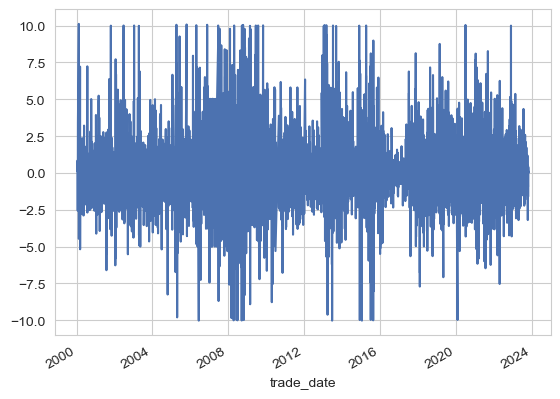

In [17]:
plt.style.use('seaborn-v0_8-deep')
plt.grid(False)
df.pct_chg.plot()

In [18]:
# 平稳性分析
from statsmodels.tsa.stattools import adfuller
adfuller(df.pct_chg)
# p value ==0.5
# >0.05accept H0:therefor non-stationary

(-32.3029212086644,
 0.0,
 5,
 5594,
 {'1%': -3.431519521496859,
  '5%': -2.8620568141154634,
  '10%': -2.5670450987031024},
 25360.016984863534)

In [19]:
# df['pct_chg']=np.log1p(df['pct_chg']+10)

In [20]:
# df

In [21]:
adfuller(df.pct_chg)

(-32.3029212086644,
 0.0,
 5,
 5594,
 {'1%': -3.431519521496859,
  '5%': -2.8620568141154634,
  '10%': -2.5670450987031024},
 25360.016984863534)

In [22]:
import os

# 创建新文件夹
result_folder = "pct_change_new"
os.makedirs(os.path.join(result_folder, Ts_code), exist_ok=True)

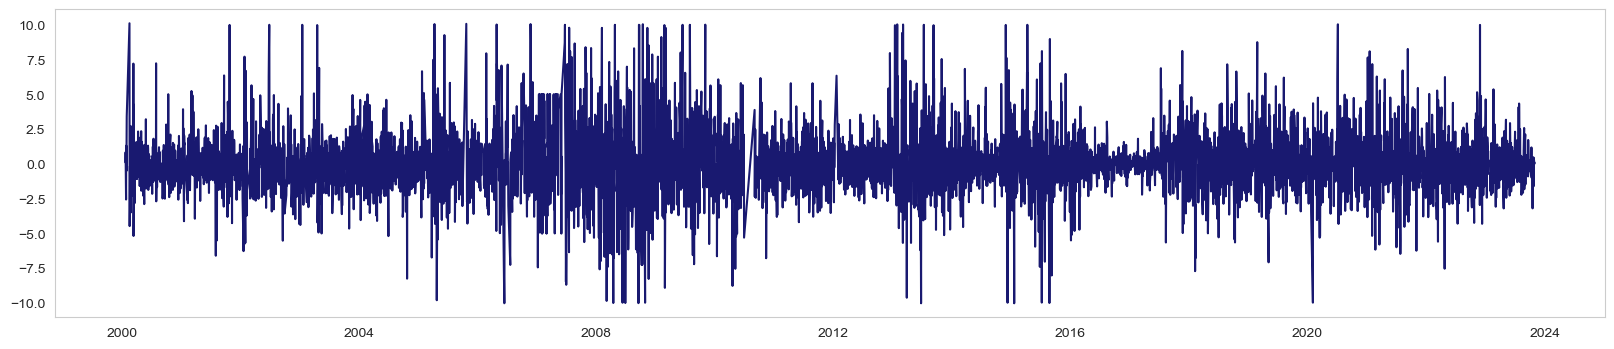

In [23]:
plt.figure(figsize=(20,4))
plt.plot(df.index,df['pct_chg'],color='midnightblue',)
plt.grid(False)
#plt.savefig('pct_change_new/{}/pctchg.png'.format(Ts_code))

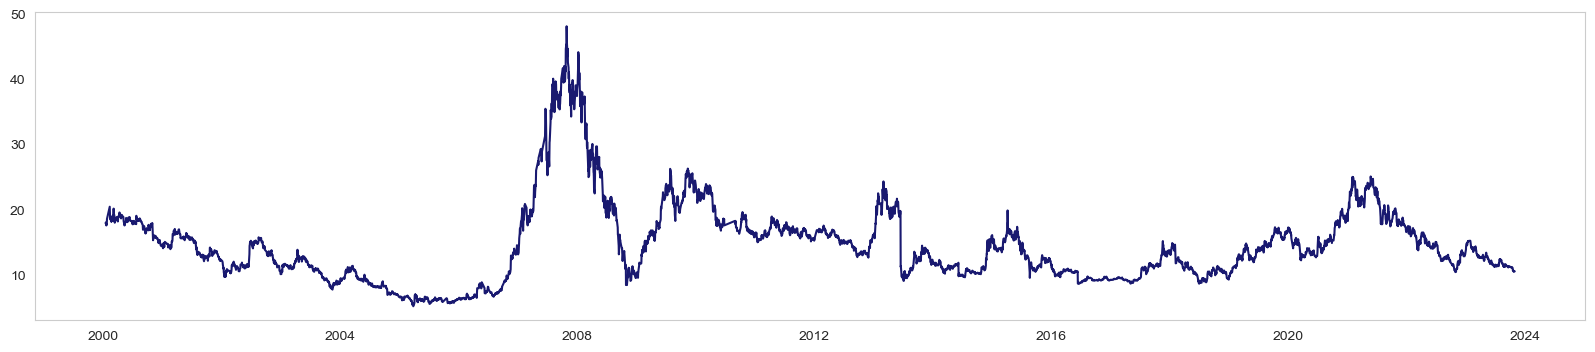

In [24]:
plt.figure(figsize=(20,4))
plt.grid(False)
plt.plot(df.index,df['close'],color='midnightblue',)


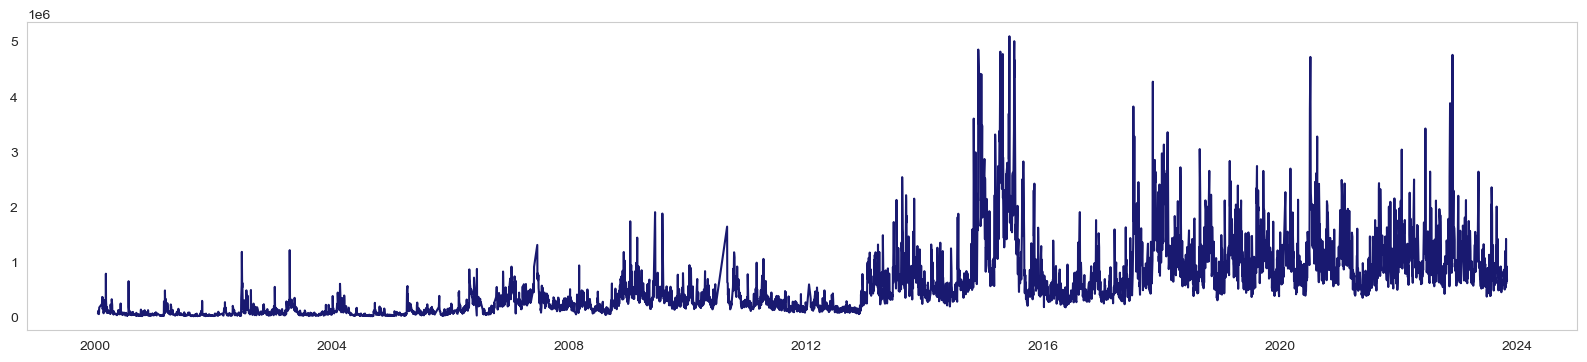

In [25]:

plt.figure(figsize=(20, 4))
plt.grid(False)
plt.plot(df.index, df['vol'],color='midnightblue',)

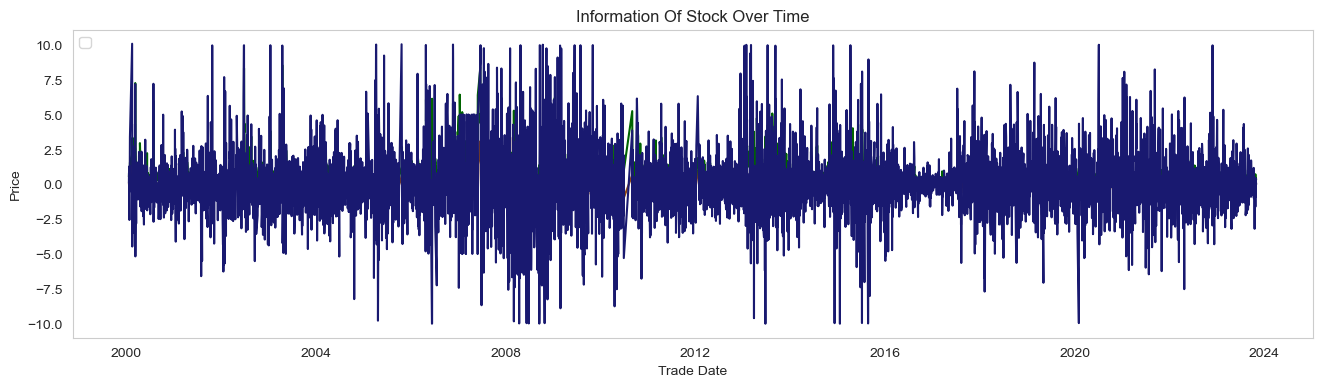

In [26]:
# 提取需要绘制的数据列
# data_columns = ['change', 'turnover_rate', 'turnover_rate_f', 'pct_chg']
# plot_data = df[data_columns]

# 绘制图形
plt.figure(figsize=(16, 4))
plt.plot(df.index,df['change'],color='saddlebrown')
plt.plot(df.index,df['turnover_rate'],color='darkgreen')
plt.plot(df.index,df['pct_chg'],color='midnightblue')
#plot_data.plot()
plt.xlabel('Trade Date')
plt.ylabel('Price')
plt.title('Information Of Stock Over Time')
plt.legend(loc='upper left')
plt.grid(False)
#plt.savefig('pct_change_new/{}/stock.png'.format(Ts_code))
plt.show()

In [27]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5600 entries, 2000-01-20 to 2023-10-31
Data columns (total 25 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   amount           5600 non-null   float64
 1   change           5600 non-null   float64
 2   circ_mv          5600 non-null   float64
 3   close            5600 non-null   float64
 4   dv_ratio         5600 non-null   float64
 5   dv_ttm           3688 non-null   float64
 6   float_share      5600 non-null   float64
 7   free_share       5600 non-null   float64
 8   high             5600 non-null   float64
 9   low              5600 non-null   float64
 10  open             5600 non-null   float64
 11  pb               5600 non-null   float64
 12  pct_chg          5600 non-null   float64
 13  pe               5600 non-null   float64
 14  pe_ttm           5600 non-null   float64
 15  pre_close        5600 non-null   float64
 16  ps               5600 non-null   float64
 

In [28]:
print(df.isnull().sum())

amount                0
change                0
circ_mv               0
close                 0
dv_ratio              0
dv_ttm             1912
float_share           0
free_share            0
high                  0
low                   0
open                  0
pb                    0
pct_chg               0
pe                    0
pe_ttm                0
pre_close             0
ps                    0
ps_ttm                0
total_mv              0
total_share           0
trade_date            0
turnover_rate         0
turnover_rate_f       0
vol                   0
volume_ratio          0
dtype: int64


### 相关性分析

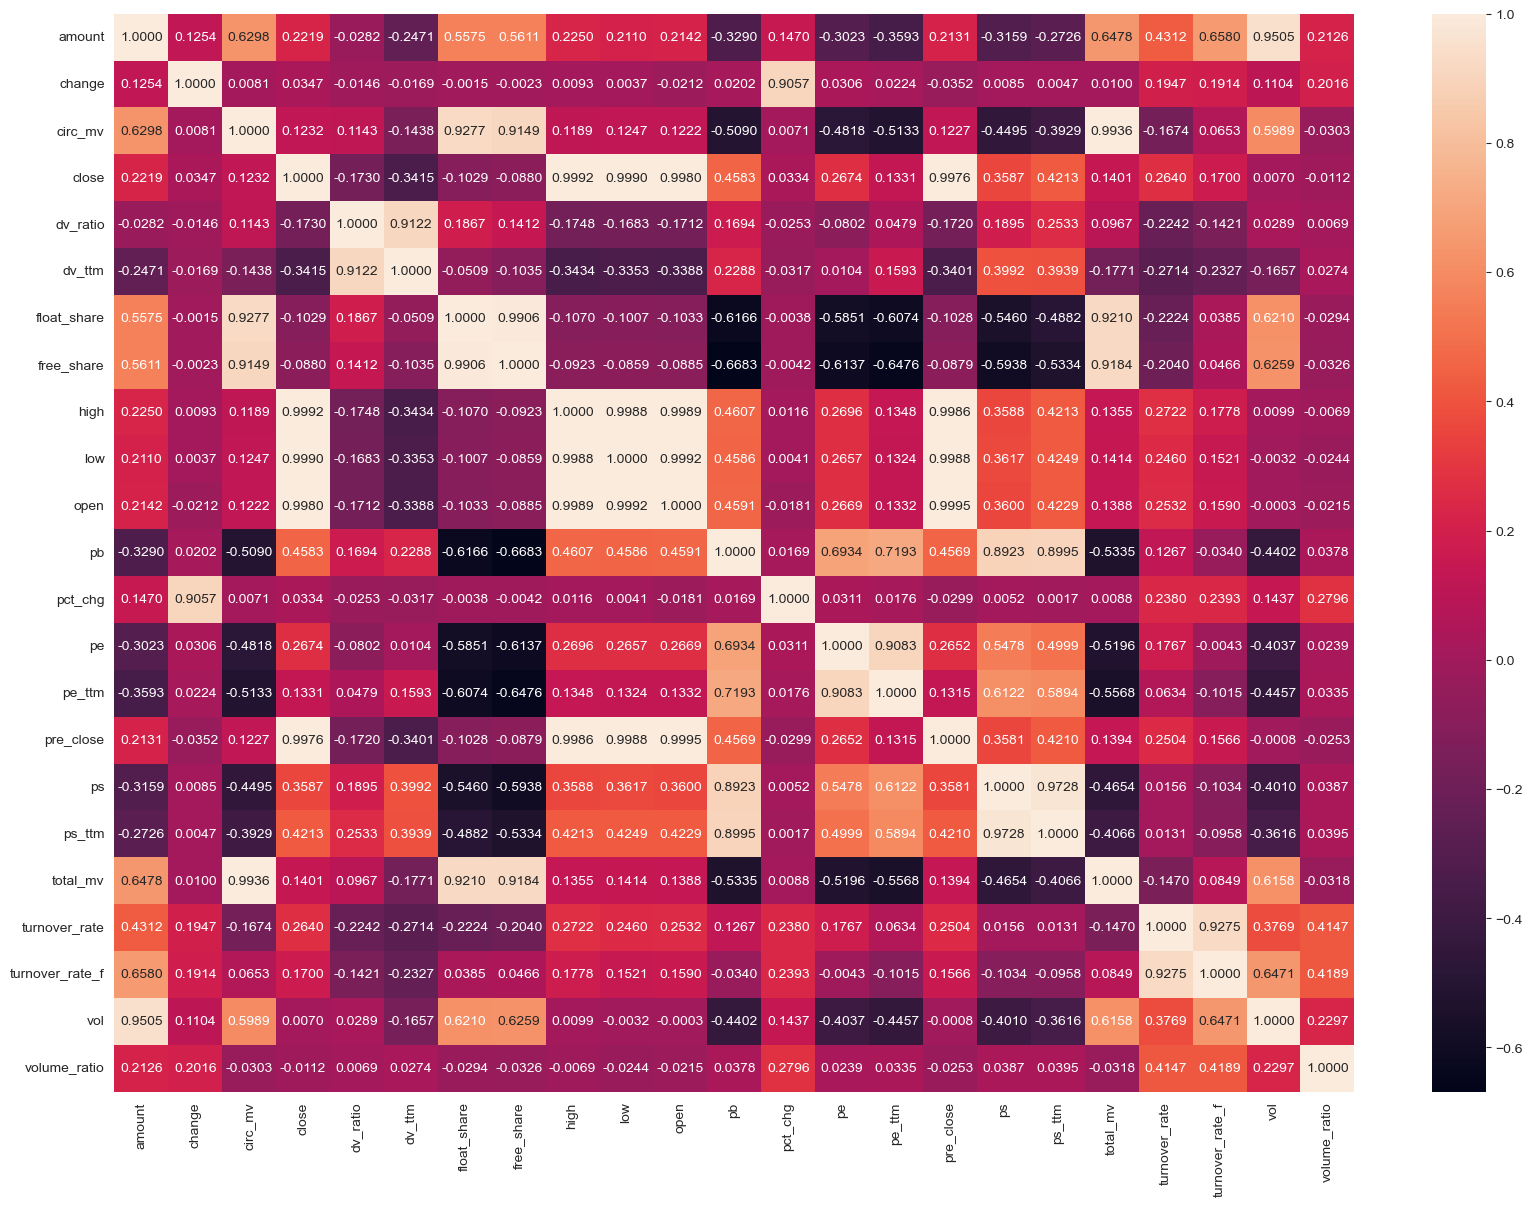

In [29]:
import seaborn as sns
new_df = df[['amount','change','circ_mv','close','dv_ratio','dv_ttm','float_share','free_share','high','low','open','pb','pct_chg','pe','pe_ttm','pre_close','ps','ps_ttm','total_mv','turnover_rate','turnover_rate_f','vol','volume_ratio']].copy()
# new_df = df[['amount','change','close','float_share','free_share','high','low','open','pb','pct_chg','pe','pe_ttm','pre_close','total_mv','turnover_rate','turnover_rate_f','vol']].copy() # for index
list_columns = new_df.columns
plt.figure(figsize=(20,14))
sns.heatmap(new_df[list_columns].corr(),annot=True,fmt='.4f',linewidths=0)
#plt.savefig('pct_change_new/{}/corr.png'.format(Ts_code))
plt.show()

In [30]:
corr_1=new_df.corr()
corr_1['pct_chg'].sort_values(ascending=False)

pct_chg            1.000000
change             0.905688
volume_ratio       0.279631
turnover_rate_f    0.239252
turnover_rate      0.238029
amount             0.146960
vol                0.143727
close              0.033449
pe                 0.031096
pe_ttm             0.017602
pb                 0.016891
high               0.011638
total_mv           0.008825
circ_mv            0.007062
ps                 0.005173
low                0.004060
ps_ttm             0.001733
float_share       -0.003755
free_share        -0.004229
open              -0.018095
dv_ratio          -0.025299
pre_close         -0.029912
dv_ttm            -0.031688
Name: pct_chg, dtype: float64

In [31]:
# 取出需要的列作为训练特征和预测目标
data = df[['change', 'volume_ratio', 'turnover_rate_f','turnover_rate','amount','vol','pct_chg']].values.reshape(-1, 7)
# data = df[['change', 'pe_ttm', 'amount','close','total_mv','pct_chg']].values.reshape(-1, 6) # for index
#data = df[['change', 'volume_ratio', 'turnover_rate_f','turnover_rate','free_share','total_mv','close','pe','pct_chg']].values.reshape(-1, 9)


# 归一化数据
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

In [32]:
data

array([[ 2.00000000e-02,  1.30000000e+00,  7.28000000e-01, ...,
         1.03508667e+05,  5.84380000e+04,  1.10000000e-01],
       [ 1.50000000e-01,  1.85000000e+00,  1.07460000e+00, ...,
         1.54067431e+05,  8.62620000e+04,  8.40000000e-01],
       [-4.60000000e-01,  2.13000000e+00,  1.40160000e+00, ...,
         1.96243595e+05,  1.12517000e+05, -2.56000000e+00],
       ...,
       [ 4.00000000e-02,  1.20000000e+00,  1.12710000e+00, ...,
         9.57587534e+05,  9.19771360e+05,  3.84200000e-01],
       [ 0.00000000e+00,  9.50000000e-01,  9.87300000e-01, ...,
         8.37646002e+05,  8.05689550e+05,  0.00000000e+00],
       [ 1.00000000e-02,  7.30000000e-01,  8.00000000e-01, ...,
         6.82212138e+05,  6.52855230e+05,  9.57000000e-02]])

In [33]:
df

,amount,change,circ_mv,close,dv_ratio,dv_ttm,float_share,free_share,high,low,...,pre_close,ps,ps_ttm,total_mv,total_share,trade_date,turnover_rate,turnover_rate_f,vol,volume_ratio
trade_date,,,,,,,,,,,,,,,,,,,,,
2000-01-20,1.035087e+05,0.02,1.908581e+06,17.81,4.8785,4.8785,1.071634e+05,80277.1362,17.90,17.55,...,17.79,14.0744,15.3205,2.763840e+06,1.551847e+05,20000120,0.5453,0.7280,58438.00,1.30
2000-01-21,1.540674e+05,0.15,1.924655e+06,17.96,4.8378,4.8378,1.071634e+05,80277.1362,18.26,17.66,...,17.81,14.1929,15.4495,2.787117e+06,1.551847e+05,20000121,0.8050,1.0746,86262.00,1.85
2000-01-24,1.962436e+05,-0.46,1.875360e+06,17.50,4.9650,4.9650,1.071634e+05,80277.1362,17.95,17.20,...,17.96,13.8294,15.0538,2.715732e+06,1.551847e+05,20000124,1.0500,1.4016,112517.00,2.13
2000-01-25,1.492599e+05,0.23,1.900008e+06,17.73,4.9033,4.9033,1.071634e+05,80277.1362,18.29,17.50,...,17.50,14.0112,15.2517,2.751425e+06,1.551847e+05,20000125,0.7812,1.0429,83719.00,1.23
2000-01-26,8.386298e+04,-0.09,1.890363e+06,17.64,4.9256,4.9256,1.071634e+05,80277.1362,17.88,17.50,...,17.73,13.9400,15.1742,2.737458e+06,1.551847e+05,20000126,0.4453,0.5945,47723.00,0.63
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-10-25,1.470972e+06,-0.17,2.014296e+07,10.38,2.1965,2.7457,1.940555e+06,860090.6226,10.54,10.36,...,10.55,1.1197,1.1901,2.014334e+07,1.940592e+06,20231025,0.7273,1.6410,1411449.68,1.93
2023-10-26,6.219153e+05,0.03,2.020117e+07,10.41,2.1902,2.7378,1.940555e+06,816042.7512,10.42,10.30,...,10.38,1.1230,1.1935,2.020156e+07,1.940592e+06,20231026,0.3092,0.7352,599991.47,0.68
2023-10-27,9.575875e+05,0.04,2.027880e+07,10.45,2.1818,2.7273,1.940555e+06,816042.7512,10.48,10.33,...,10.41,1.1273,1.1981,2.027918e+07,1.940592e+06,20231027,0.4740,1.1271,919771.36,1.20


In [34]:
#df.to_csv('output.csv')

In [35]:
scaled_data

array([[0.4880597 , 0.06501057, 0.05641026, ..., 0.01123943, 0.00978667,
        0.50322901],
       [0.50746269, 0.09408034, 0.08648531, ..., 0.01712522, 0.01526675,
        0.53949329],
       [0.41641791, 0.10887949, 0.11485965, ..., 0.02203514, 0.0204378 ,
        0.37059116],
       ...,
       [0.49104478, 0.05972516, 0.09104083, ..., 0.11066677, 0.17943057,
        0.51685047],
       [0.48507463, 0.04651163, 0.07891015, ..., 0.09670382, 0.15696159,
        0.49776453],
       [0.48656716, 0.03488372, 0.06265782, ..., 0.07860903, 0.12686011,
        0.50251863]])

#### K线图
type
'candle'：蜡烛图（默认选项），表示开盘价、最高价、最低价和收盘价之间的关系。
'ohlc'：开盘-最高-最低-收盘图，以线段表示开盘价和收盘价，通过纵线表示最高价和最低价。
'line'：线图，仅使用收盘价绘制一条线。
'renko'：Renko图，根据价格变动绘制砖块。
'pnf'：点数图（Point and Figure），根据价格变动绘制点和X

style

'classic'：经典样式，黑色背景。
'yahoo'：Yahoo金融样式，白色背景，较浓的蜡烛图颜色。
'charles'：类似于Yahoo样式，但颜色较浅。
'mike'：Mike Halls-Moore样式，黑色背景，较浓的蜡烛图颜色。
'blueskies'：蓝天样式，白色背景，较浅的蜡烛图颜色。
'brasil'：巴西样式，白色背景，较浅的蜡烛图颜色。
'charles'：Charles Dow样式，白色背景，较浅的蜡烛图颜色。

reference:https://www.codenong.com/cs105319421/

In [36]:
import mplfinance as mpf
# 绘制K线图
# 设置所需的时间范围
start_date = '2023-5-31'
end_date = '2023-10-31'
df_plot = df.loc[start_date:end_date].copy()

# 设置market colors
# up:设置K线线柱颜色，up意为收盘价大于等于开盘价
# down:与up相反，这样设置与国内K线颜色标准相符
# edge:K线线柱边缘颜色(i代表继承自up和down的颜色)，下同。详见官方文档)
# wick:灯芯(上下影线)颜色
# volume:成交量直方图的颜色
# inherit:是否继承，选填
mc = mpf.make_marketcolors(
    up='darkred', 
    down='darkgreen', 
    edge='i', 
    wick='i', 
    volume='in', 
    inherit=False)
    
# 设置图形风格
# gridaxis:设置网格线位置
# gridstyle:设置网格线线型
# y_on_right:设置y轴位置是否在右
s = mpf.make_mpf_style(
    gridaxis='both', 
    y_on_right=False, 
    marketcolors=mc,
)
#    gridstyle='-.', 


mpf.plot(df_plot, type='candle', style=s,title='Stock K-line Chart',savefig='pct_change_new/{}/k-line.png'.format(Ts_code),figratio=(20,10),returnfig=True)

# # 设置x轴标签旋转
# plt.xticks(rotation=45)
# # 显示图形
# plt.show()

(<Figure size 1150x575 with 2 Axes>, [<Axes: ylabel='Price'>, <Axes: >])

### 创建训练集和测试集

In [37]:
# 定义训练集和测试集的比例
train_ratio = 0.90

# 计算划分的索引
train_size = int(len(scaled_data) * train_ratio)
test_size = len(scaled_data) - train_size
# 
# 划分训练集和测试集
train_data = scaled_data[:train_size, :]
test_data = scaled_data[train_size:, :]


In [38]:
train_size

5040

In [39]:
test_size

560

In [40]:
train_data

array([[0.4880597 , 0.06501057, 0.05641026, ..., 0.01123943, 0.00978667,
        0.50322901],
       [0.50746269, 0.09408034, 0.08648531, ..., 0.01712522, 0.01526675,
        0.53949329],
       [0.41641791, 0.10887949, 0.11485965, ..., 0.02203514, 0.0204378 ,
        0.37059116],
       ...,
       [0.59253731, 0.04809725, 0.07313983, ..., 0.20696563, 0.15425695,
        0.65990065],
       [0.45074627, 0.02906977, 0.0405484 , ..., 0.12304428, 0.09063805,
        0.44760556],
       [0.32985075, 0.0961945 , 0.14023168, ..., 0.36480822, 0.28525215,
        0.26865375]])

In [41]:
test_data

array([[0.44925373, 0.03964059, 0.07015489, ..., 0.18841714, 0.14842855,
        0.44233482],
       [0.46865672, 0.04968288, 0.08180832, ..., 0.21561137, 0.171184  ,
        0.47207154],
       [0.47910448, 0.0359408 , 0.0595861 , ..., 0.16007802, 0.12779736,
        0.48837556],
       ...,
       [0.49104478, 0.05972516, 0.09104083, ..., 0.11066677, 0.17943057,
        0.51685047],
       [0.48507463, 0.04651163, 0.07891015, ..., 0.09670382, 0.15696159,
        0.49776453],
       [0.48656716, 0.03488372, 0.06265782, ..., 0.07860903, 0.12686011,
        0.50251863]])

### 准备数据集

In [42]:
def create_dataset(dataset, time_steps=1):
    data_x, data_y = [], []
    for i in range(len(dataset) - time_steps):
        data_x.append(dataset[i:(i + time_steps), :])
        data_y.append(dataset[i + time_steps, -1])
    return np.array(data_x), np.array(data_y)

# 定义时间步长
time_steps = 5

# 创建训练集和测试集的数据集
train_x, train_y = create_dataset(train_data, time_steps)
test_x, test_y = create_dataset(test_data, time_steps)

# 将输入数据重塑为LSTM所需的三维形状
train_x = np.reshape(train_x, (train_x.shape[0], train_x.shape[1], train_x.shape[2]))
test_x = np.reshape(test_x, (test_x.shape[0], test_x.shape[1], test_x.shape[2]))

In [43]:
train_x

array([[[0.4880597 , 0.06501057, 0.05641026, ..., 0.01123943,
         0.00978667, 0.50322901],
        [0.50746269, 0.09408034, 0.08648531, ..., 0.01712522,
         0.01526675, 0.53949329],
        [0.41641791, 0.10887949, 0.11485965, ..., 0.02203514,
         0.0204378 , 0.37059116],
        [0.51940299, 0.06131078, 0.08373465, ..., 0.01656555,
         0.01476589, 0.56284153],
        [0.47164179, 0.02959831, 0.04482624, ..., 0.00895239,
         0.0076763 , 0.47242921]],

       [[0.50746269, 0.09408034, 0.08648531, ..., 0.01712522,
         0.01526675, 0.53949329],
        [0.41641791, 0.10887949, 0.11485965, ..., 0.02203514,
         0.0204378 , 0.37059116],
        [0.51940299, 0.06131078, 0.08373465, ..., 0.01656555,
         0.01476589, 0.56284153],
        [0.47164179, 0.02959831, 0.04482624, ..., 0.00895239,
         0.0076763 , 0.47242921],
        [0.52238806, 0.04651163, 0.07275804, ..., 0.01444868,
         0.0127668 , 0.56830601]],

       [[0.41641791, 0.10887949, 0.1

In [44]:
train_x.shape

(5035, 5, 7)

In [45]:
train_y

array([0.56830601, 0.66716344, 1.        , ..., 0.65990065, 0.44760556,
       0.26865375])

In [46]:
train_y.shape

(5035,)

In [47]:
test_x

array([[[0.44925373, 0.03964059, 0.07015489, ..., 0.18841714,
         0.14842855, 0.44233482],
        [0.46865672, 0.04968288, 0.08180832, ..., 0.21561137,
         0.171184  , 0.47207154],
        [0.47910448, 0.0359408 , 0.0595861 , ..., 0.16007802,
         0.12779736, 0.48837556],
        [0.43134328, 0.04915433, 0.07878867, ..., 0.20359171,
         0.16528511, 0.41308992],
        [0.61343284, 0.0512685 , 0.08968719, ..., 0.2367065 ,
         0.18656659, 0.70355688]],

       [[0.46865672, 0.04968288, 0.08180832, ..., 0.21561137,
         0.171184  , 0.47207154],
        [0.47910448, 0.0359408 , 0.0595861 , ..., 0.16007802,
         0.12779736, 0.48837556],
        [0.43134328, 0.04915433, 0.07878867, ..., 0.20359171,
         0.16528511, 0.41308992],
        [0.61343284, 0.0512685 , 0.08968719, ..., 0.2367065 ,
         0.18656659, 0.70355688],
        [0.44328358, 0.0332981 , 0.05104777, ..., 0.14240064,
         0.11113274, 0.43342772]],

       [[0.47910448, 0.0359408 , 0.0

In [48]:
test_x.shape

(555, 5, 7)

### 构建 LSTM 模型：

In [49]:
from keras.layers import Dropout, BatchNormalization


# 定义LSTM模型
model = Sequential([
    LSTM(units=64, activation='tanh',return_sequences=True,input_shape=(time_steps, train_x.shape[2])),
    #Dropout(0.2),
    LSTM(units=64,return_sequences=True),
    #Dropout(0.2),
    LSTM(units=64),
    #Dropout(0.2),
    Dense(units=1,activation='tanh')
])

Metal device set to: Apple M1 Pro


In [50]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 5, 64)             18432     
                                                                 
 lstm_1 (LSTM)               (None, 5, 64)             33024     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 84,545
Trainable params: 84,545
Non-trainable params: 0
_________________________________________________________________
None


In [51]:
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.optimizers import SGD, Adam, Adagrad, Adadelta, Adamax, Nadam
from keras.optimizers.legacy.rmsprop import RMSProp

# optimizers
sgd_optimizer = SGD(learning_rate=0.001)
sgd_momentum_optimizer = SGD(learning_rate=0.001, momentum=0.9)
adam_optimizer = Adam(learning_rate=0.001,beta_1=0.9,beta_2=0.999)
nadam_optimizer = Nadam(learning_rate=0.001, decay=0.9)
adagrad_optimizer = Adagrad(learning_rate=0.01)
adadelta_optimizer = Adadelta(learning_rate=0.01, rho=0.95)
adamax_optimizer = Adamax(learning_rate=0.001, decay=0.9)
rmsprop_optimizer = RMSProp(learning_rate=0.001, decay=0.9)

# 编译模型
model.compile(optimizer=rmsprop_optimizer, loss='mse')

# 调参
es = EarlyStopping(monitor='val_loss',patience=10,mode='min',verbose=1)
mc = ModelCheckpoint('best_model.h5',monitor='val_loss',mode='min',save_best_only=True,verbose=1)

# 训练模型
history=model.fit(train_x, train_y, validation_data=(test_x,test_y),epochs=100, batch_size=64,callbacks=[es,mc])

Epoch 1/100


2023-11-15 15:44:56.716959: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


79/79 [==============================] - ETA: 0s - loss: 0.0306
Epoch 1: val_loss improved from inf to 0.00937, saving model to best_model.h5
79/79 [==============================] - 5s 35ms/step - loss: 0.0306 - val_loss: 0.0094
Epoch 2/100
79/79 [==============================] - ETA: 0s - loss: 0.0148
Epoch 2: val_loss improved from 0.00937 to 0.00917, saving model to best_model.h5
79/79 [==============================] - 2s 23ms/step - loss: 0.0148 - val_loss: 0.0092
Epoch 3/100
78/79 [============================>.] - ETA: 0s - loss: 0.0146
Epoch 3: val_loss did not improve from 0.00917
79/79 [==============================] - 2s 21ms/step - loss: 0.0146 - val_loss: 0.0092
Epoch 4/100
79/79 [==============================] - ETA: 0s - loss: 0.0146
Epoch 4: val_loss did not improve from 0.00917
79/79 [==============================] - 2s 31ms/step - loss: 0.0146 - val_loss: 0.0092
Epoch 5/100
79/79 [==============================] - ETA: 0s - loss: 0.0145
Epoch 5: val_loss did not 

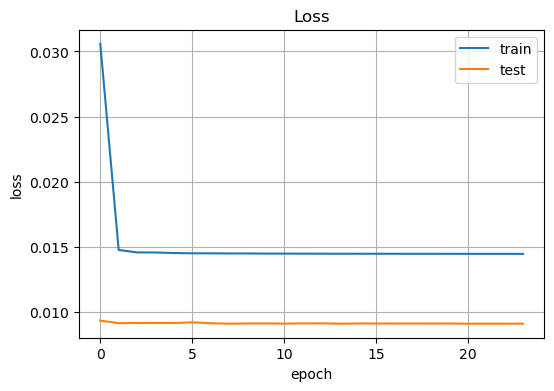

In [52]:
# 绘制损失图
plt.figure(figsize=(6,4))
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.title('Loss')
plt.ylabel('loss',)
plt.xlabel('epoch')
plt.legend()
plt.savefig('pct_change_new/{}/loss.png'.format(Ts_code))
plt.show()

### 绘制预测结果图表

In [53]:
# 使用训练好的模型进行预测
import keras
#model=keras.models.load_model('best_model.h5')
train_pred = model.predict(train_x)
test_pred = model.predict(test_x)

# 反归一化预测结果
train_pred = scaler.inverse_transform(np.concatenate((train_x[:, -1, :-1], train_pred), axis=1))[:, -1]
test_pred = scaler.inverse_transform(np.concatenate((test_x[:, -1, :-1], test_pred), axis=1))[:, -1]

# # 创建日期索引
# train_dates = df['trade_date'].values[time_steps:train_size]
# test_dates = df['trade_date'].values[train_size + time_steps:]


18/18 [==============================] - 0s 5ms/step


### 训练集

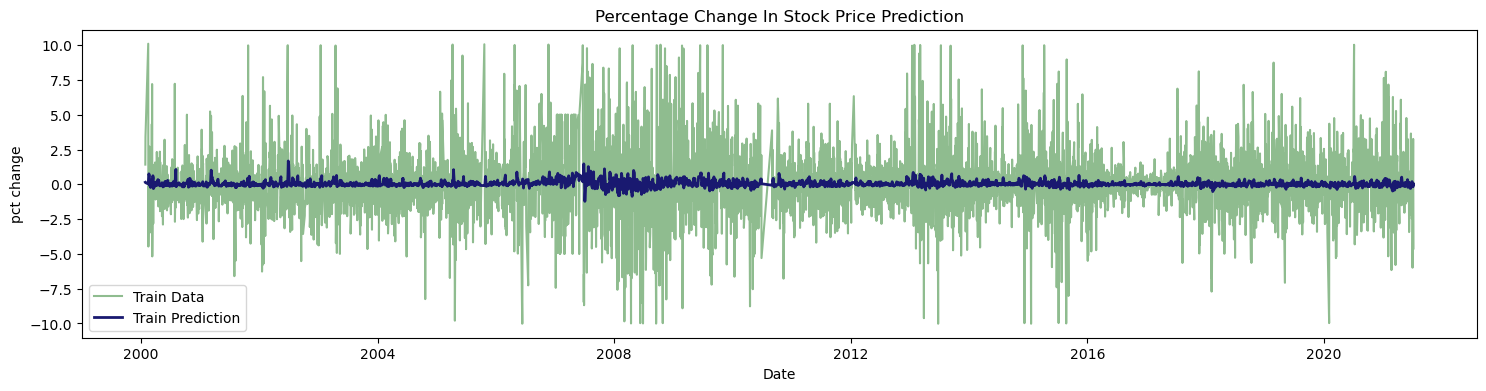

In [54]:
# 绘制训练集的真实值和预测值
plt.style.use('seaborn-v0_8-deep')
train_range = range(time_steps, train_size)
plt.figure(figsize=(18,4))
plt.plot(df.index[train_range],data[time_steps:train_size,-1], label='Train Data',color='darkseagreen')

plt.plot(df.index[train_range],train_pred, label='Train Prediction',color='midnightblue',linewidth=2)

plt.xlabel('Date')
plt.ylabel('pct change')
plt.title('Percentage Change In Stock Price Prediction')
plt.legend()
plt.grid(False)
#plt.savefig('pct_change_new/{}/train.png'.format(Ts_code))
plt.show()

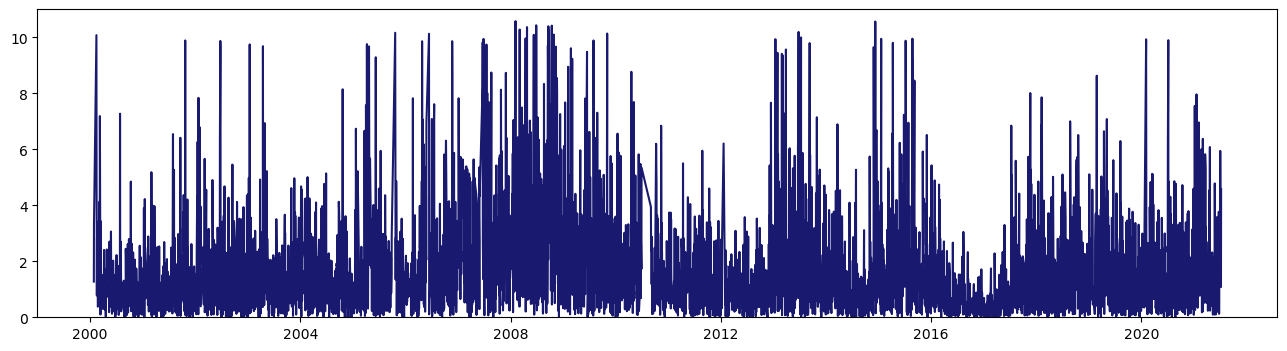

In [55]:
plt.figure(figsize=(16,4))
plt.plot(df.index[train_range],abs(train_pred-data[time_steps:train_size,-1]),color='midnightblue')
plt.ylim(0,11)
#plt.savefig('pct_change_new/{}/difference1.png'.format(Ts_code))
plt.grid(False)
plt.show()

### 测试集

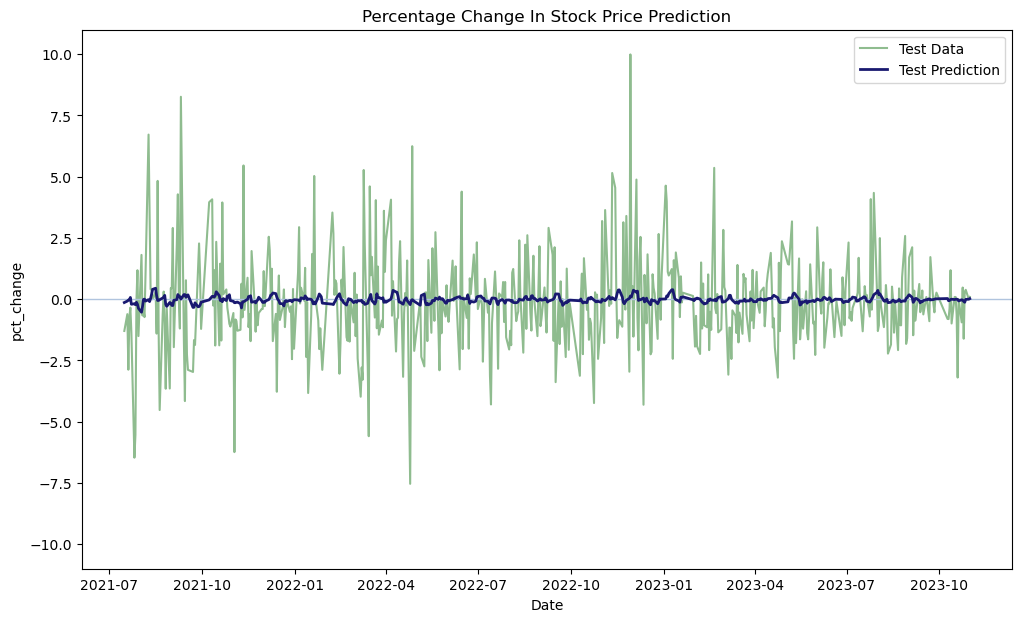

In [56]:
# 绘制测试集的真实值和预测值

test_range = range(train_size + time_steps, len(data))
plt.figure(figsize=(12,7))

plt.plot(df.index[test_range],data[train_size + time_steps:, -1], label='Test Data',color='darkseagreen')
plt.axhline(y=0, linewidth=1,color='lightsteelblue')
plt.plot(df.index[test_range],test_pred, label='Test Prediction',color='midnightblue',linewidth=2)

plt.xlabel('Date')
plt.ylabel('pct_change')
plt.ylim(-11,11)
plt.title('Percentage Change In Stock Price Prediction')
plt.legend()
plt.grid(False)
#plt.savefig('pct_change_new/{}/test.png'.format(Ts_code))
plt.show()

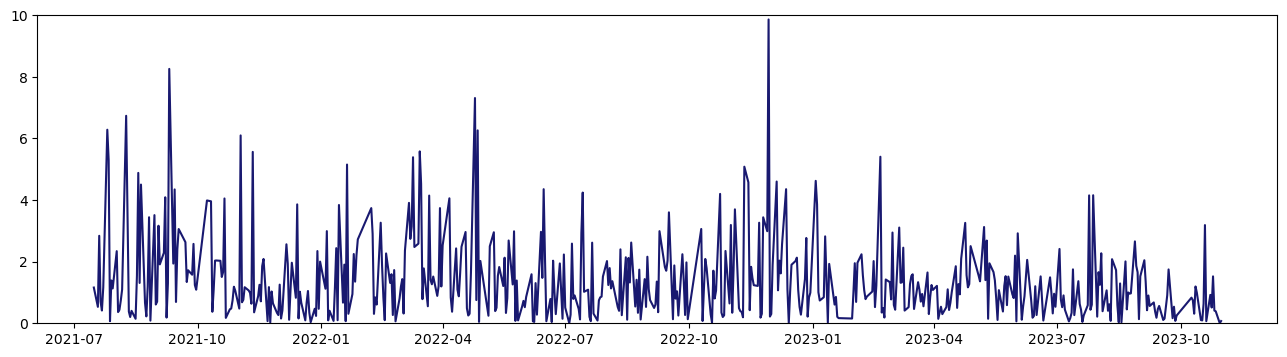

In [57]:
plt.figure(figsize=(16,4))
plt.ylim(0,10)
plt.plot(df.index[test_range],abs(test_pred-data[train_size + time_steps:,-1]),color='midnightblue')
plt.grid(False)
#plt.savefig('pct_change_new/{}/difference2'.format(Ts_code))
plt.show()

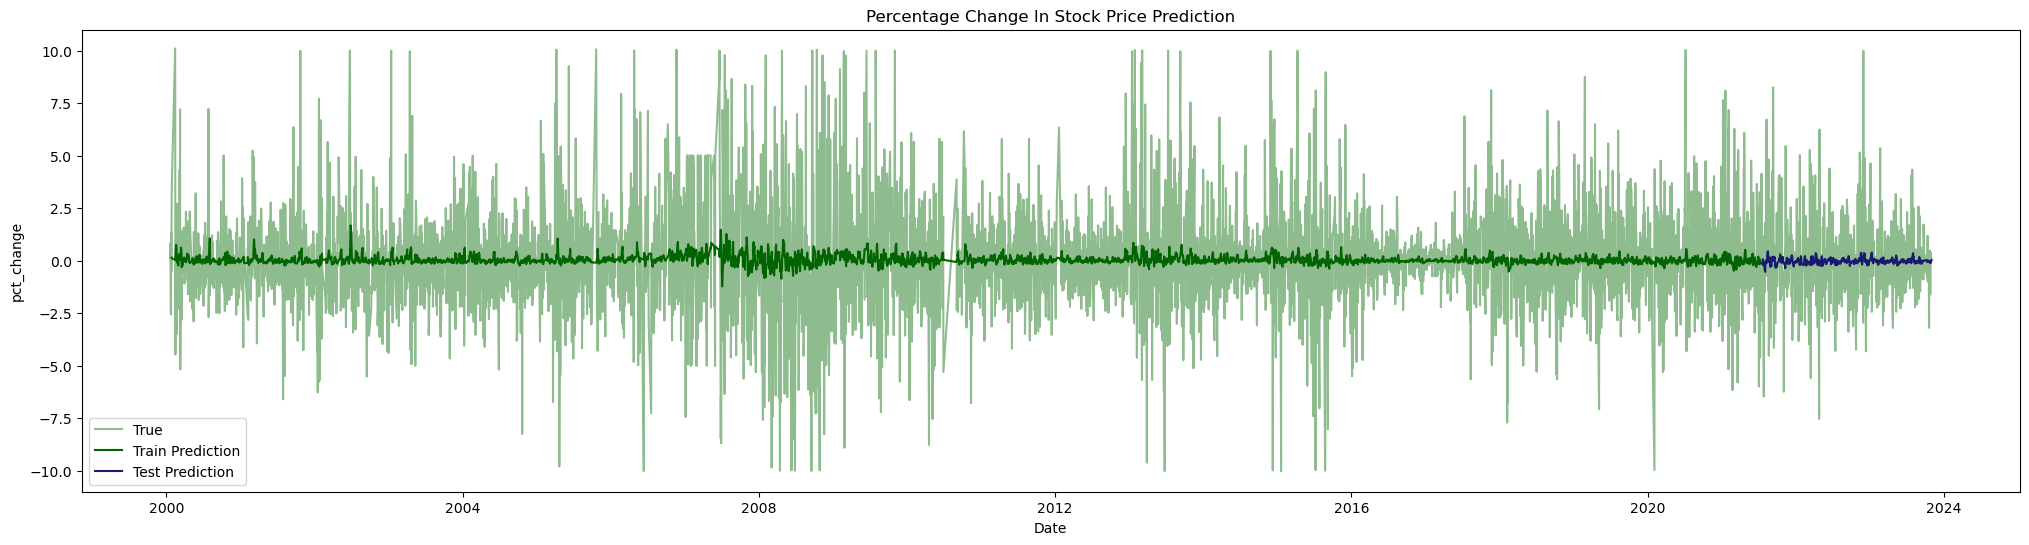

In [58]:
plt.style.use('seaborn-v0_8-deep')
plt.figure(figsize=(25, 6))
train_range = range(time_steps, train_size)
test_range = range(train_size + time_steps, len(data))
plt.plot(df.index,df['pct_chg'],label='True',color='darkseagreen')#,color='b'
#plt.plot(df.index[train_range], data[train_range, -1], label='True Data', color='b')
plt.plot(df.index[train_range], train_pred, label='Train Prediction',color='darkgreen')#, color='m'
#plt.plot(df.index[test_range], data[test_range, -1], label='True Data', color='b')
plt.plot(df.index[test_range], test_pred, label='Test Prediction',color='midnightblue')#, color='orange'
plt.ylim(-11,11)
plt.xlabel('Date')
plt.ylabel('pct_change')
plt.title('Percentage Change In Stock Price Prediction')
plt.legend()
plt.grid(False)
#plt.savefig('pct_change_new/{}/train_test.png'.format(Ts_code))
plt.savefig('2year.png')
plt.show()

#### 均方根误差 和 平均绝对误差 和均方误差

In [59]:
rmse = np.sqrt(mean_squared_error(test_pred, data[train_size + time_steps:, -1]))
mae = mean_absolute_error(test_pred, data[train_size + time_steps:, -1])
mse=mean_squared_error(test_pred, data[train_size + time_steps:,-1])
print('RMSE is {}'.format(rmse))
print('MAE is {}'.format(mae))
print('MSE is {}'.format(mse))

RMSE is 1.9237721678555237
MAE is 1.389416917853957
MSE is 3.700899353815541


# CODE END 以下忽略

In [60]:
df['increase'] = np.where(df['pct_chg'] > 0, 1, 0)
df['increase']

trade_date
2000-01-20    1
2000-01-21    1
2000-01-24    0
2000-01-25    1
2000-01-26    0
             ..
2023-10-25    0
2023-10-26    1
2023-10-27    1
2023-10-30    0
2023-10-31    1
Name: increase, Length: 5600, dtype: int64

In [61]:
# 记录data[time_steps:train_size,-1]的条件结果
data_condition = np.where(data[time_steps:train_size, -1] > 0, 1, 0)

# 记录train_pred的条件结果
train_pred_condition = np.where(train_pred > 0, 1, 0)

# 使用train_range作为索引
index_range = df.index[train_range]

# 将结果存储在新的变量中
record = {
    'data_condition': data_condition,
    'train_pred_condition': train_pred_condition,
    'index_range': index_range
}

In [62]:
record

{'data_condition': array([1, 1, 1, ..., 1, 0, 0]),
 'train_pred_condition': array([1, 1, 1, ..., 0, 1, 0]),
 'index_range': DatetimeIndex(['2000-01-27', '2000-01-28', '2000-02-14', '2000-02-15',
                '2000-02-16', '2000-02-17', '2000-02-18', '2000-02-21',
                '2000-02-22', '2000-02-23',
                ...
                '2021-06-25', '2021-06-28', '2021-06-29', '2021-06-30',
                '2021-07-01', '2021-07-02', '2021-07-05', '2021-07-06',
                '2021-07-07', '2021-07-08'],
               dtype='datetime64[ns]', name='trade_date', length=5035, freq=None)}

In [63]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# 计算准确率
accuracy = accuracy_score(data_condition, train_pred_condition)

# 计算精确率
precision = precision_score(data_condition, train_pred_condition)

# 计算召回率
recall = recall_score(data_condition, train_pred_condition)

# 计算F1值
f1 = f1_score(data_condition, train_pred_condition)

print(f"准确率: {accuracy:.4f}")
print(f"精确率: {precision:.4f}")
print(f"召回率: {recall:.4f}")
print(f"F1值: {f1:.4f}")

准确率: 0.4929
精确率: 0.4774
召回率: 0.5472
F1值: 0.5099


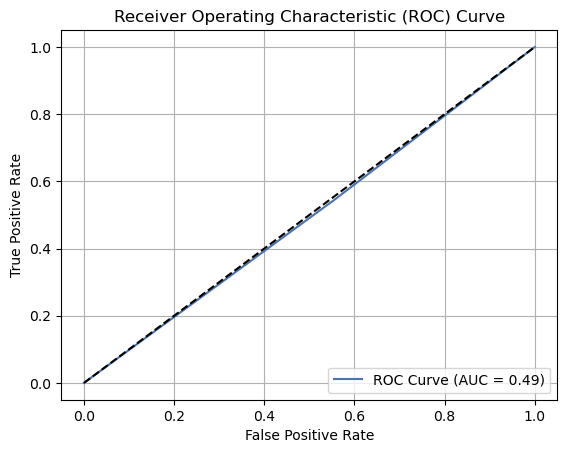

In [64]:
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# 计算 AUC-ROC 曲线下的面积
auc_roc = roc_auc_score(data_condition, train_pred_condition)

# 计算 ROC 曲线的假正例率和真正例率
fpr, tpr, thresholds = roc_curve(data_condition, train_pred_condition)

# 绘制 ROC 曲线
plt.plot(fpr, tpr, label='ROC Curve (AUC = %0.2f)' % auc_roc)
plt.plot([0, 1], [0, 1], 'k--')  # 绘制对角线
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

### 测试集

In [65]:
test_condition = np.where(data[train_size + time_steps:, -1] > 0, 1, 0)

test_pred_condition = np.where(test_pred > 0, 1, 0)

# 将结果存储在新的变量中
test_record = {
    'data_condition': test_condition,
    'train_pred_condition': test_pred_condition,
    'index_range': df.index[test_range]
}

In [66]:
# 计算准确率
test_accuracy = accuracy_score(test_condition, test_pred_condition)

# 计算精确率
test_precision = precision_score(test_condition, test_pred_condition)

# 计算召回率
test_recall = recall_score(test_condition, test_pred_condition)

# 计算F1值
test_f1 = f1_score(test_condition, test_pred_condition)

print(f"准确率: {test_accuracy:.4f}")
print(f"精确率: {test_precision:.4f}")
print(f"召回率: {test_recall:.4f}")
print(f"F1值: {test_f1:.4f}")

准确率: 0.4937
精确率: 0.3935
召回率: 0.3617
F1值: 0.3769


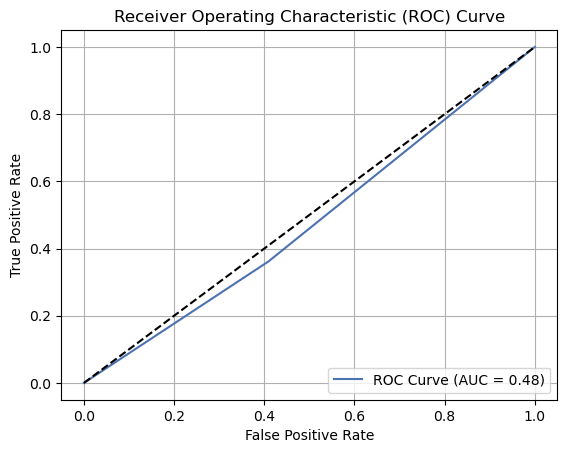

In [67]:
# 计算 AUC-ROC 曲线下的面积
auc_roc_test = roc_auc_score(test_condition, test_pred_condition)

# 计算 ROC 曲线的假正例率和真正例率
fpr_test, tpr_test, thresholds_test = roc_curve(test_condition, test_pred_condition)

# 绘制 ROC 曲线
plt.plot(fpr_test, tpr_test, label='ROC Curve (AUC = %0.2f)' % auc_roc_test)
plt.plot([0, 1], [0, 1], 'k--')  # 绘制对角线
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

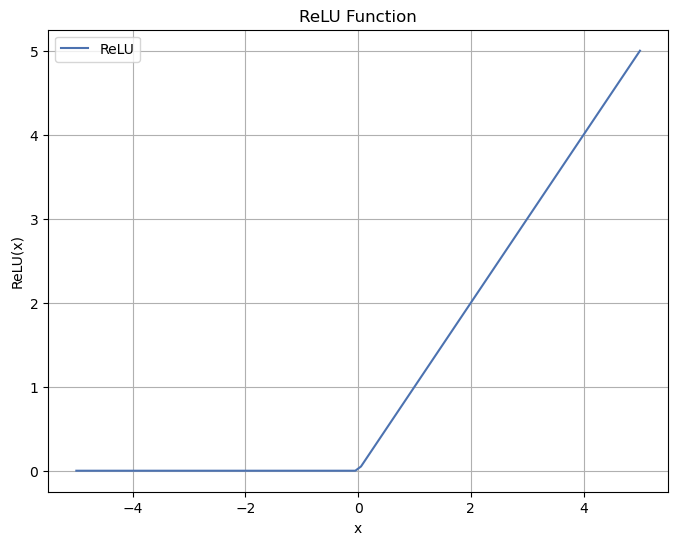

In [68]:
import numpy as np
import matplotlib.pyplot as plt

# Define the ReLU function
def relu(x):
    return np.maximum(0, x)



# Generate x values
x = np.linspace(-5, 5, 100)

# Compute y values for ReLU function
y_relu = relu(x)



# Plot ReLU function
plt.figure(figsize=(8, 6))
plt.plot(x, y_relu, label='ReLU')
plt.xlabel('x')
plt.ylabel('ReLU(x)')
plt.title('ReLU Function')
plt.grid(True)
plt.legend()

# Show the plot
plt.show()



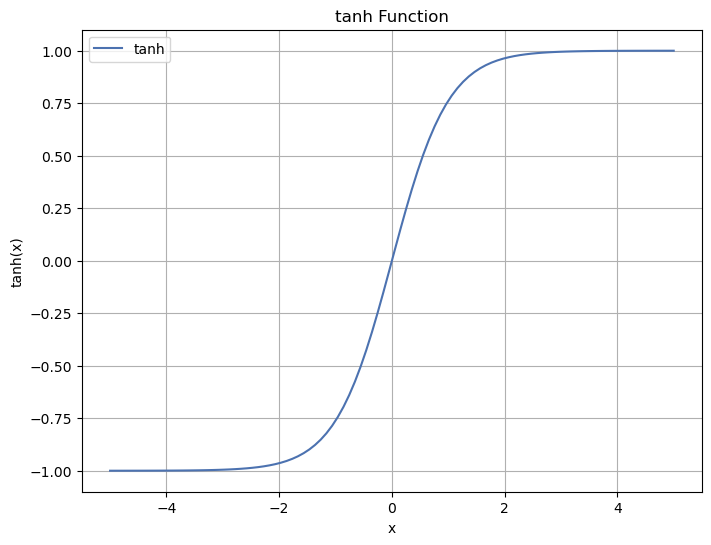

In [69]:
# Define the tanh function
def tanh(x):
    return np.tanh(x)
# Compute y values for tanh function
y_tanh = tanh(x)
# Plot tanh function
plt.figure(figsize=(8, 6))
plt.plot(x, y_tanh, label='tanh')
plt.xlabel('x')
plt.ylabel('tanh(x)')
plt.title('tanh Function')
plt.grid(True)
plt.legend()

# Show the plot
plt.show()